In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree


lung_cancer = pd.read_csv("survey lung cancer.csv")
lung_cancer.head()

,GENDER,AGE,SMOKING,YELLOW_FINGERS,ANXIETY,PEER_PRESSURE,CHRONIC DISEASE,FATIGUE,ALLERGY,WHEEZING,ALCOHOL CONSUMING,COUGHING,SHORTNESS OF BREATH,SWALLOWING DIFFICULTY,CHEST PAIN,LUNG_CANCER
0,M,69,1,2,2,1,1,2,1,2,2,2,2,2,2,YES
1,M,74,2,1,1,1,2,2,2,1,1,1,2,2,2,YES
2,F,59,1,1,1,2,1,2,1,2,1,2,2,1,2,NO
3,M,63,2,2,2,1,1,1,1,1,2,1,1,2,2,NO
4,F,63,1,2,1,1,1,1,1,2,1,2,2,1,1,NO


In [10]:
# check for missing values
print(lung_cancer.isnull().sum())

GENDER                   0
AGE                      0
SMOKING                  0
YELLOW_FINGERS           0
ANXIETY                  0
PEER_PRESSURE            0
CHRONIC DISEASE          0
FATIGUE                  0
ALLERGY                  0
WHEEZING                 0
ALCOHOL CONSUMING        0
COUGHING                 0
SHORTNESS OF BREATH      0
SWALLOWING DIFFICULTY    0
CHEST PAIN               0
LUNG_CANCER              0
dtype: int64


In [11]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
lung_cancer["GENDER"] = le.fit_transform(lung_cancer["GENDER"])
lung_cancer["LUNG_CANCER"] = le.fit_transform(lung_cancer["LUNG_CANCER"])
print(lung_cancer[["LUNG_CANCER", "GENDER"]].head())

   LUNG_CANCER  GENDER
0            1       1
1            1       1
2            0       0
3            0       1
4            0       0


In [28]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X = lung_cancer.drop("LUNG_CANCER", axis=1)
y = lung_cancer["LUNG_CANCER"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
xgb_clf = xgb.XGBClassifier(objective="binary:logistic",
                            n_estimators=100,
                            max_depth=6,
                            learning_rate=0.5,
                            seed=123,
                            eval_metric="logloss")

xgb_clf.fit(X_train, y_train)
y_pred = xgb_clf.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE: %f" % (rmse))

RMSE: 0.219971


In [13]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix, roc_curve

print("Accuracy: ", accuracy_score(y_test, y_pred))
print("Precision: ", precision_score(y_test, y_pred))
print("Recall: ", recall_score(y_test, y_pred))
print("F1 Score: ", f1_score(y_test, y_pred))
print("ROC AUC Score: ", roc_auc_score(y_test, y_pred))
report = classification_report(y_test, y_pred)
print(report)

Accuracy:  0.9516129032258065
Precision:  0.9811320754716981
Recall:  0.9629629629629629
F1 Score:  0.9719626168224299
ROC AUC Score:  0.9189814814814815
              precision    recall  f1-score   support

           0       0.78      0.88      0.82         8
           1       0.98      0.96      0.97        54

    accuracy                           0.95        62
   macro avg       0.88      0.92      0.90        62
weighted avg       0.95      0.95      0.95        62



In [19]:
housing_dmatrix = xgb.DMatrix(data=X, label=y)

params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'max_depth': 3

}
cv_results = xgb.cv(
    dtrain=housing_dmatrix,
    params=params,
    nfold=3,
    num_boost_round=1000,
    early_stopping_rounds=50,
    as_pandas=True,
    seed=123
)

best_n_estimators = len(cv_results)
print(f"Best n_estimators: {best_n_estimators}")
final_xgb = xgb.XGBClassifier(objective='binary:logistic',
                              n_estimators=best_n_estimators,
                              seed=123,
                              eval_metric='logloss')
final_xgb.fit(X, y)

Best n_estimators: 11


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=11,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [24]:
cv_results = xgb.cv(dtrain=housing_dmatrix,
                    params=params, nfold=3,
                    num_boost_round=50,
                    metrics="rmse",
                    as_pandas=True,
                    seed=123,
                    early_stopping_rounds=10)
print(cv_results)

    train-rmse-mean  train-rmse-std  test-rmse-mean  test-rmse-std
0          0.306443        0.006220        0.316214       0.014910
1          0.284544        0.004623        0.303739       0.008489
2          0.265714        0.002480        0.293775       0.004930
3          0.254667        0.002324        0.289969       0.002549
4          0.241458        0.001694        0.284952       0.002184
5          0.234396        0.002585        0.284120       0.006088
6          0.226359        0.003433        0.281596       0.005940
7          0.220932        0.004128        0.281700       0.006619
8          0.214306        0.004424        0.278573       0.007867
9          0.209216        0.003653        0.276426       0.011030
10         0.203415        0.003342        0.275703       0.012543


In [27]:
# Create list of max_depth values
max_depths = [2, 5, 10, 20]
best_rmse = []

# Systematically vary the max_depth
for curr_val in max_depths:

    params["max_depth"] = curr_val

    # Perform cross-validation
    cv_results = xgb.cv(dtrain=lung_dmatrix, params=params, nfold=3, num_boost_round=10, early_stopping_rounds=5, metrics="rmse", as_pandas=True, seed=123)

    # Append the final round rmse to best_rmse
    best_rmse.append(cv_results["test-rmse-mean"].tail().values[-1])

# Print the resultant DataFrame
print(pd.DataFrame(list(zip(max_depths, best_rmse)),columns=["max_depth","best_rmse"]))

   max_depth  best_rmse
0          2   0.282636
1          5   0.282497
2         10   0.294504
3         20   0.294504


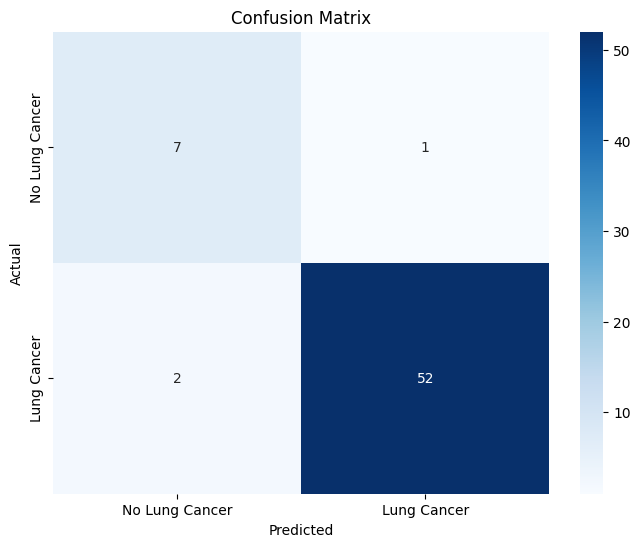

In [29]:
# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix using seaborn for better visualization
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Lung Cancer', 'Lung Cancer'],
            yticklabels=['No Lung Cancer', 'Lung Cancer'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


Feature Importances:
                  Feature  Importance
0                ALLERGY     0.200858
1   SWALLOWING DIFFICULTY    0.152938
2       ALCOHOL CONSUMING    0.086900
3           PEER_PRESSURE    0.082270
4          YELLOW_FINGERS    0.081305
5                WHEEZING    0.064014
6                FATIGUE     0.062283
7                 ANXIETY    0.047943
8         CHRONIC DISEASE    0.047844
9                COUGHING    0.042910
10                SMOKING    0.032836
11    SHORTNESS OF BREATH    0.027629
12                 GENDER    0.024414
13                    AGE    0.023641
14             CHEST PAIN    0.022212


<ipython-input-31-cbc9b6f45791>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=features_df, palette='viridis')


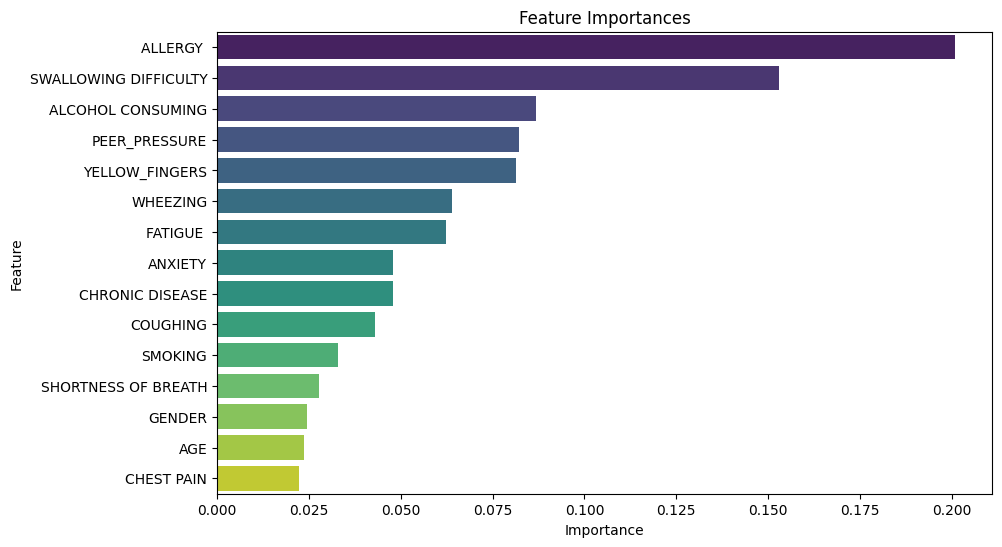

In [31]:
# Feature importance from the Decision Tree (using best_model from GridSearchCV)
# Changed best_model to rnd_clf as best_model was not defined and rnd_clf is the trained model
feature_importances = xgb_clf.feature_importances_

# Create a DataFrame to display feature importances
features_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})
features_df = features_df.sort_values('Importance', ascending=False).reset_index(drop=True)

# Print the feature importances
print("\nFeature Importances:")
print(features_df)

# Visualize feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=features_df, palette='viridis')
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

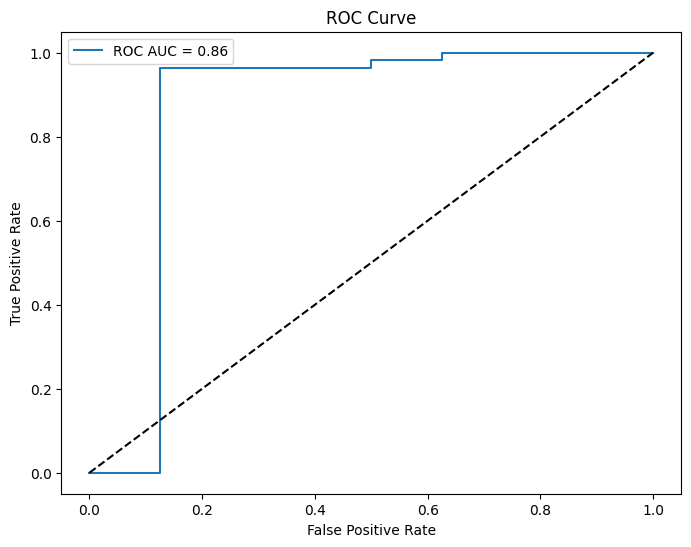

In [33]:
# Calculate ROC curve
# Get predicted probabilities for the positive class
y_pred_proba = xgb_clf.predict_proba(X_test)[:, 1]

# Calculate ROC AUC score
test_roc_auc = roc_auc_score(y_test, y_pred_proba)

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba, pos_label=1) # Ensure pos_label is correct

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC AUC = {test_roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line (random classifier)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

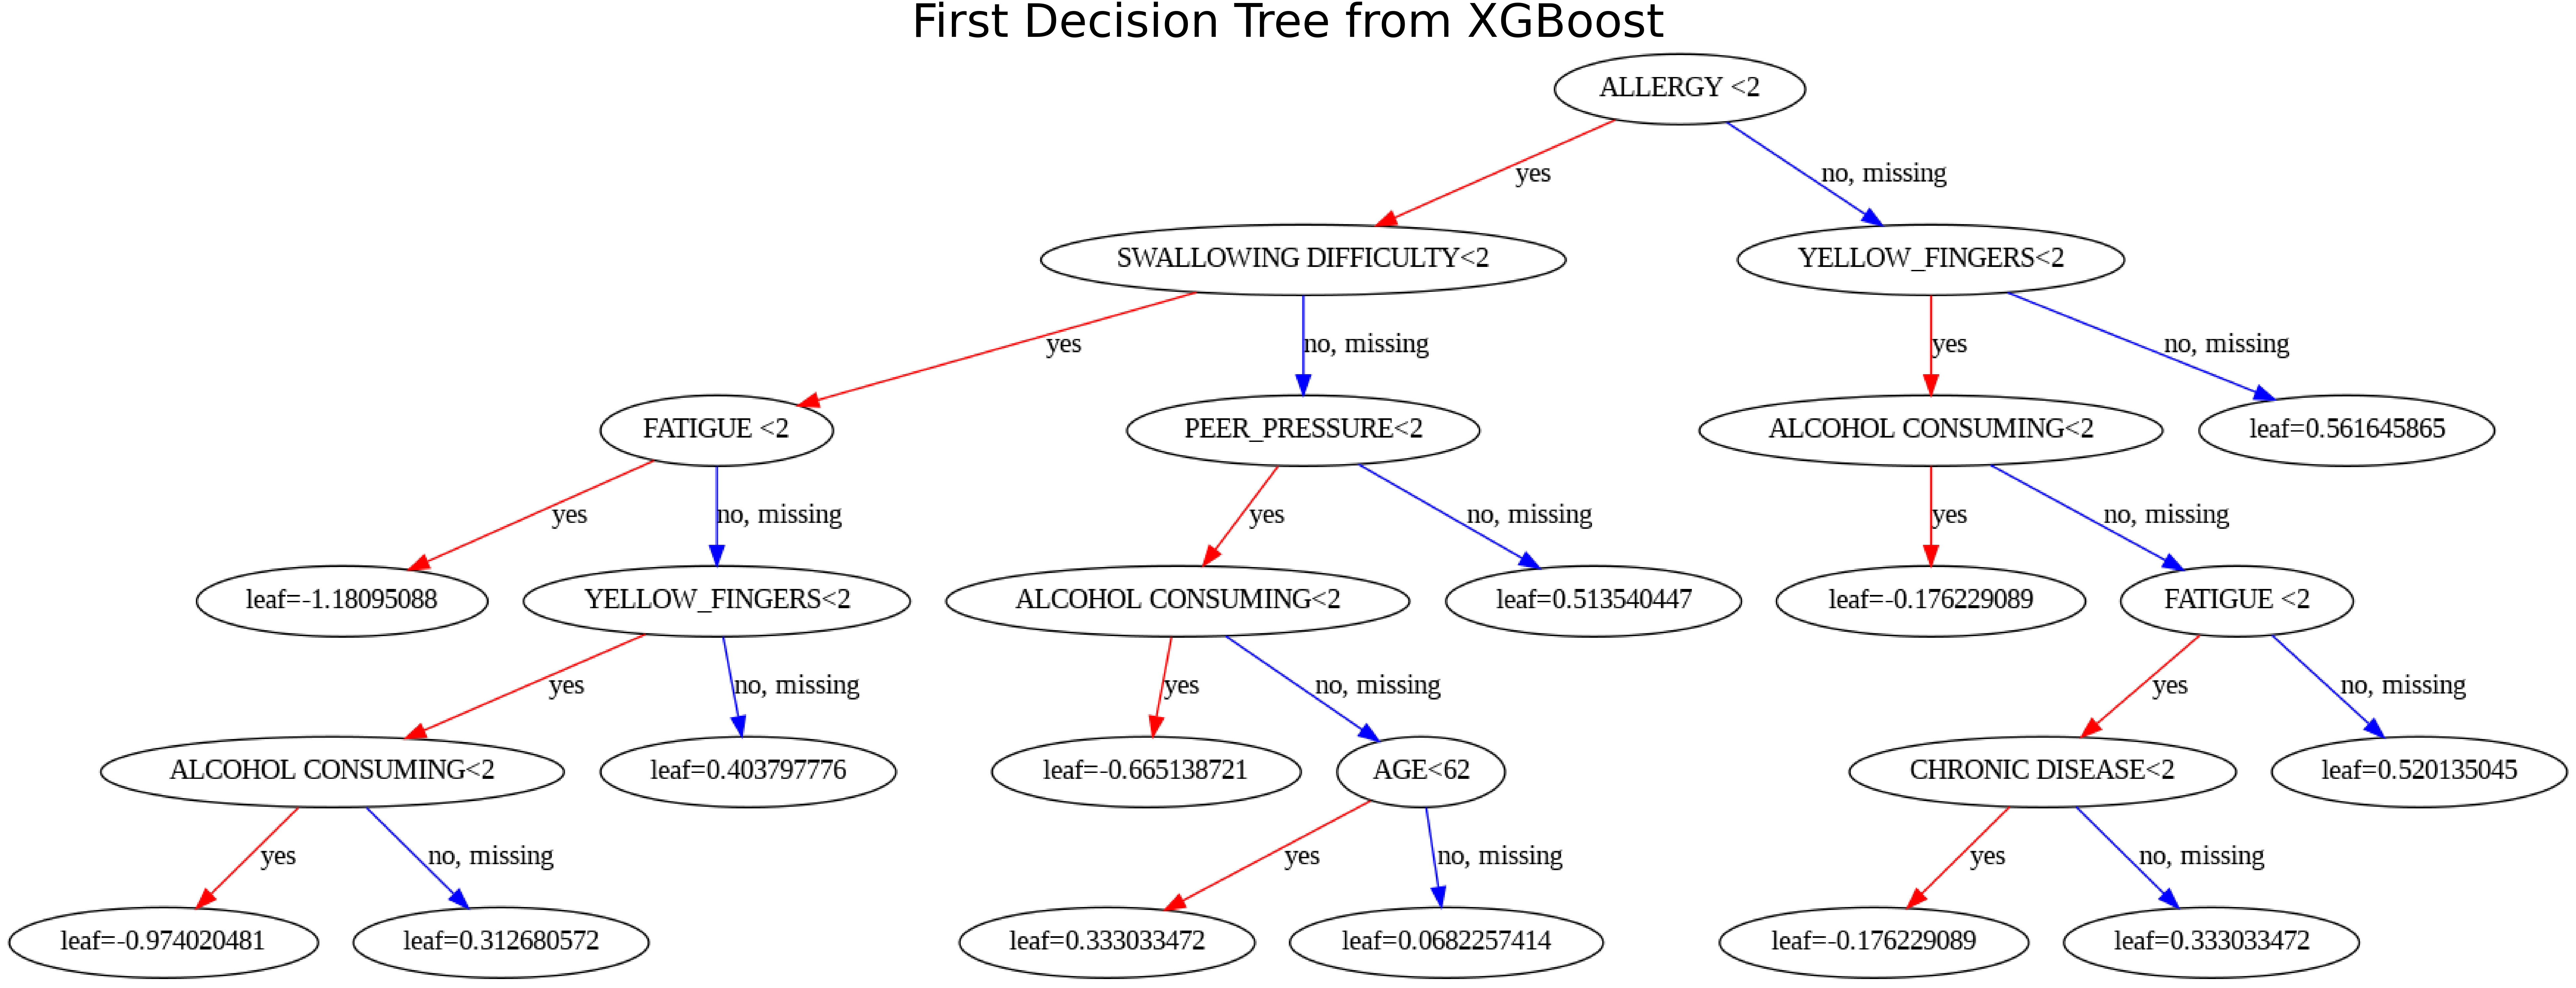

In [45]:
import xgboost as xgb
from xgboost import plot_tree
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [200, 100]
plt.rcParams['figure.dpi'] = 50

plot_tree(xgb_clf, num_trees=0)
plt.title('First Decision Tree from XGBoost', fontsize=200)
plt.show()